In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (28,28,1)
num_classes = 10

In [3]:
#%%capture one
#Load model from disk
model_name = 'MNIST-L0'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='mnist', transform='dct',seed=SEED)
print ('Total Model Params: %d' % model.num_params)
#model.load_model(model_save_path, weights_save_path) 
epochs = 20
model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

../models/neural_network.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  x_rec[i,:,:,0]= f_recon


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Total Model Params: 1199882
Train on 120000 samples, validate on 10000 samples
Epoch 1/20
120000/120000 [==============================] - 8s 65us/step - loss: 0.2396 - acc: 0.9281 - val_loss: 0.0804 - val_acc: 0.9742
Epoch 2/20
120000/120000 [==============================] - 7s 56us/step - loss: 0.0953 - acc: 0.9721 - val_loss: 0.0507 - val_acc: 0.9838
Epoch 3/20
120000/120000 [==============================] - 7s 57us/step - loss: 0.0765 - acc: 0.9773 - val_loss: 0.0472 - val_acc: 0.9844
Epoch 4/20
120000/120000 [==============================] - 7s 57us/step - loss: 0.0648 - acc: 0.9805 - val_loss: 0.0434 - val_acc: 0.9853
Epoch 5/20
120000/120000 [==============================] - 7s 57us/step - loss: 0.0565 - acc: 0.9829 - val_loss: 0.0393 - val_acc: 0.9876
Epoch 6/20
120000/120000 [========

In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.val_data, model.val_labels)[1]))

10000/10000 [==============================] - 1s 96us/step
Model Accuracy: 0.99140


In [5]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [6]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [ ]:
%%capture four
import time
#Get Regular, JSMA, DF, and CW test points
reg_data = model.test_data[test_indices]
start_time = time.time()
jsma_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='JSMA', iterations=100)
print("--- JSMA: %s seconds ---" % (time.time() - start_time))
start_time = time.time()
cwl0_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='CW-l0')
print("--- CW: %s seconds ---" % (time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
#%%capture five
#reg_data = np.load('data/reg_data_mnist_dct_l0-socp.npy')
#jsma_data = np.load('data/jsma_data_mnist_dct_l0-socp.npy')
#cwl0_data = np.load('data/cwl0_data_mnist_dct_l0-socp.npy')


In [ ]:
%%capture five
np.save('data/reg_data_mnist_l0', reg_data)
np.save('data/jsma_data_mnist_l0', jsma_data)
np.save('data/cwl0_data_mnist_l0', cwl0_data)

In [ ]:
%%capture temp
model.save_model(model_save_path, weights_save_path)   

In [ ]:
%%capture six
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='mnist',transform='dct-matrix', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

In [44]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW-l0: %.5f' % (model.model.evaluate(cwl0_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 96us/step
Model Accuracy REG: 0.98500
1000/1000 [==============================] - 0s 84us/step
Model Accuracy CW-l0: 0.01300
1000/1000 [==============================] - 0s 71us/step
Model Accuracy JSMA: 0.61000


Training Data: 


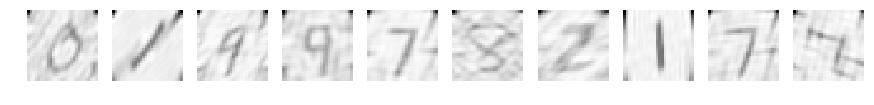

In [45]:
#Lets visualize training data
x_vis = np.random.choice(range(0,num_train_samples), 10)
print ('Training Data: ')
visualize(train_data[x_vis].reshape(-1,*input_shape), 10, '../figures/train-mnist_l0')

Regular: 


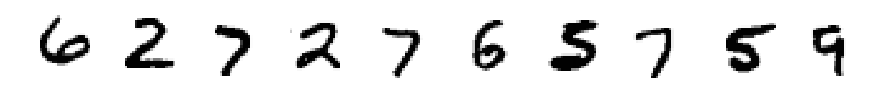

CW-l0: 


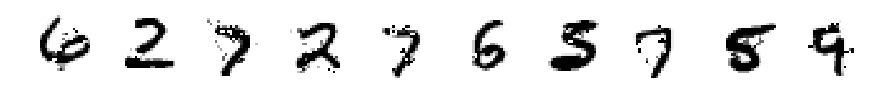

JSMA: 


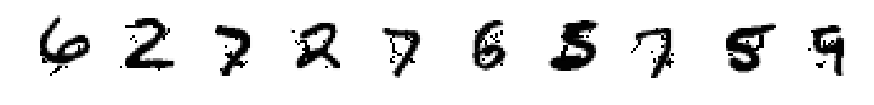

In [43]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-mnist_l0')
print ('CW-l0: ')
visualize(cwl0_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-mnist_l0')
print ('JSMA: ')
visualize(jsma_data[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-mnist_l0')

In [ ]:
%%capture seven
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
cwl0_preds = model.model.predict(cwl0_data.reshape(-1,*input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
cwl0_labels = preds_to_labels(cwl0_preds)
jsma_labels = preds_to_labels(jsma_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
cwl0_idx = np.where(np.argmax(cwl0_preds, axis=1) != true_preds)[0]
jsma_idx = np.where(np.argmax(jsma_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
cwl0_data_fil = cwl0_data[cwl0_idx]
jsma_data_fil = jsma_data[jsma_idx]


#Filter labels to be used
cwl0_labels_fil = cwl0_labels[cwl0_idx]
jsma_labels_fil = jsma_labels[jsma_idx]

In [31]:
#Get l-0 distortion 
print ('CW-l0: %.5f' % (avg_l0_dist(reg_data[cwl0_idx], cwl0_data_fil)))
print ('JSMA: %.5f' % (avg_l0_dist(reg_data[jsma_idx], jsma_data_fil)))

CW-l0: 15.00000
JSMA: 17.00000


In [27]:
#Form the DCT matrix
D = np.zeros((784,784))
for p in range(784):
    for q in range(784):
        if p == 0:
            D[p,q] = 1/np.sqrt(784.0)
        else:
            D[p,q] = np.sqrt(2/784.0)*(  math.cos(  (math.pi*(2*q + 1)*p) / (2*784.0)   )    )
        

In [25]:
def iht_t_mat(y,img,t,D, T=100,k=40):
    x_hat = np.zeros(y.shape) 
    e_hat = np.zeros(y.shape)
    for i in range(T):
        x_hat,_ = get_top_bot_k_vec(np.dot(D,(y - e_hat)), k)
        e_hat,_ = get_top_bot_k_vec(y - np.dot(D.T,x_hat), t)  
    return x_hat

In [26]:
def get_top_and_bot_k(X,k):
    idx = bn.argpartition(X, X.size-k, axis=None)[-k:]
    width = X.shape[1]
    idx = np.array([divmod(i, width) for i in idx])
    top = np.zeros((X.shape)) + 1j*0
    top[idx[:,0],idx[:,1]] = X[idx[:,0],idx[:,1]]
    bot = X - top
         
    return top,bot


def get_top_bot_k_vec(x,k):
    ind = np.argpartition(x, -k)[-k:]
    temp = np.zeros(x.shape)
    temp[ind] = x[ind]
    return temp, x - temp

In [28]:
def get_topk_vec(x,k):
    ind = np.argpartition(x, -k)[-k:]
    temp = np.zeros(x.shape)
    temp[ind] = x[ind]
    return temp

In [38]:
clean_reg = np.zeros(jsma_data.shape)
for i in range(num_test_samples):
    x_adv = reg_data[i,:,:,0]
    x_hat = np.dot(D,x_adv.flatten())
    x_hat = get_topk_vec(x_hat,k=40)
    clean_reg[i,:,:,0] = np.dot(D.T,x_hat.flatten()).reshape(28,28)

In [29]:
avg=0.0
ratios = []
for i,j in enumerate(cwl0_idx):
    r = np.linalg.norm(reg_data[j]-cwl0_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.2775352787140291 0.64378196 0.00273417


In [30]:
avg=0.0
ratios = []
for i,j in enumerate(jsma_idx):
    r = np.linalg.norm(reg_data[j]-jsma_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.17909327398240565 0.90283996 0.110192336


In [32]:
%%capture eleven
#Reconstruct CW-l0
t=20
clean_cwl0_iht = np.zeros(cwl0_data.shape)
for i in range(num_test_samples):
    x_adv = cwl0_data[i,:,:,0].flatten()
    x_hat = iht_t_mat(x_adv,reg_data[i,:,:,0].flatten(), t, D, T=100,k=40)
    clean_cwl0_iht[i,:,:,0]= np.dot(D.T,x_hat.flatten()).reshape(28,28)

In [33]:
#%%capture twelve
#Reconstruct JSMA-l0
t=20
clean_jsma_iht = np.zeros(jsma_data.shape)
for i in range(num_test_samples):
    x_adv = jsma_data[i,:,:,0].flatten()
    x_hat = iht_t_mat(x_adv,reg_data[i,:,:,0].flatten(), t, D, T=100,k=40)
    clean_jsma_iht[i,:,:,0]= np.dot(D.T,x_hat.flatten()).reshape(28,28)

In [34]:
%%capture thirteen
np.save('data/clean_mnist_cwl0_dct_l0-iht', clean_cwl0_iht)
np.save('data/clean_mnist_jsma_dct_l0-iht', clean_jsma_iht)

In [41]:
x_vis = np.random.choice(range(0,num_test_samples), 10)



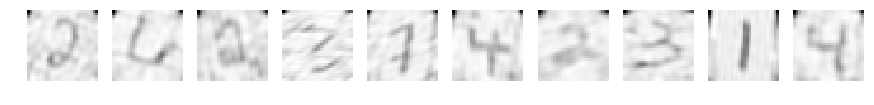

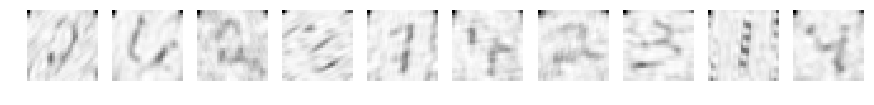

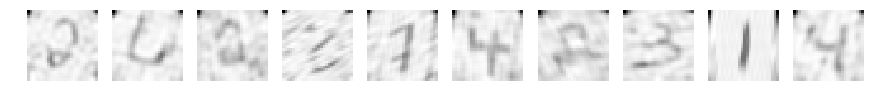

In [42]:
visualize(clean_reg[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-test-mnist_l0')
visualize(clean_cwl0_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl0-clean-mnist_l0-iht')
visualize(clean_jsma_iht[x_vis].reshape(-1,*input_shape), 10, '../figures/jsma-clean-mnist_l0-iht')

In [36]:
print ('Model Accuracy Reconstructed CW-l0: %.5f' % (model.model.evaluate(clean_cwl0_iht,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed JSMA: %.5f' % (model.model.evaluate(clean_jsma_iht,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 70us/step
Model Accuracy Reconstructed CW-l0: 0.72700
1000/1000 [==============================] - 0s 62us/step
Model Accuracy Reconstructed JSMA: 0.91400
